# Goal: Classify smartphone location as driver-side or passenger-side based on  sensor data

In [28]:
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
import numpy as np
%matplotlib inline

#### Load the processed sensor data for car trip (see "Process Smartphone Sensor Data" jupyter notebook).  On this trip, I drove my car from home to Censio and back and used SensorLog on my iPhone to track the trip.  The total time for the trip was about 15 minutes.

In [29]:
df = pd.read_csv('../Data/shaneiphone_exp2_processed.csv', index_col='DateTime')

In [30]:
# Use only userAcceleration and gyroscope data, since these features are expected to generalize well.
xyz = ['X', 'Y', 'Z']
measures = ['userAcceleration', 'gyroscope']
basefeatures = [i + j for i in measures for j in xyz]
features = [i + j for i in measures for j in xyz]

In [31]:
# Add Gaussian smoothed features
smoothfeatures = []
for i in features:
    df[i + 'sm'] = gaussian_filter(df[i], 3)
    df[i + '2sm'] = gaussian_filter(df[i], 100)
    smoothfeatures.append(i + 'sm')
    smoothfeatures.append(i + '2sm')
features.extend(smoothfeatures)

In [32]:
# Generate Jerk signal
jerkfeatures = []
for i in features:
    diffsignal = np.diff(df[i])
    df[i + 'jerk'] = np.append(0, diffsignal)
    jerkfeatures.append(i + 'jerk')
features.extend(jerkfeatures)

In [33]:
# assign class labels
class0 = (df.index > '2015-08-25 14:35:00') & \
        (df.index < '2015-08-25 14:42:00')

class1 = (df.index > '2015-08-25 14:43:00') & \
        (df.index < '2015-08-25 14:48:00')

df['class'] = -1
df['class'][class0] = 0
df['class'][class1] = 1

In [37]:
# separate into quarters for train and validation
q1 = df[(df.index <= '2015-08-25 14:38:30') & 
        (df.index > '2015-08-25 14:33:00')]
q2 = df[(df.index > '2015-08-25 14:38:30') & 
        (df.index <= '2015-08-25 14:42:00')]
q3 = df[(df.index > '2015-08-25 14:43:00') & 
        (df.index <= '2015-08-25 14:45:30')]
q4 = df[(df.index > '2015-08-25 14:45:30') & 
        (df.index <= '2015-08-25 14:48:00')]
traindf = pd.concat([q1, q3])
validationdf = pd.concat([q2, q4])

In [10]:
# check for NaNs in the dataframes
print(traindf.isnull().sum().sum())
print(validationdf.isnull().sum().sum())

0
0


In [11]:
# drop NaNs
traindf = traindf.dropna()
validationdf = validationdf.dropna()

In [12]:
# Make the training and validation sets
X_train = traindf[features].values
y_train = traindf['class'].values
X_test = validationdf[features].values
y_test = validationdf['class'].values

In [13]:
# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [14]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

(array([ 0.76409945,  0.81746513,  0.97387606,  0.93256379,  0.92284326]), 0.88216953903356132, 0.078397989661162126)


In [15]:
# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)

In [16]:
# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.596


#### 88% accuracy on the training set and 60% accuracy on the test set means we're overfitting the data.  Accelerometer data should be the key here, since a phone on the driver side will experience a different centripetal acceleration than a phone on the passenger side during turns.  But accelerometer data is super noisy!

In [17]:
# Inspect feature importances
for i, ifeature in enumerate(features):
    print(ifeature + ': %6.4f' % clf.feature_importances_[i])

userAccelerationX: 0.0002
userAccelerationY: 0.0003
userAccelerationZ: 0.0006
gyroscopeX: 0.0303
gyroscopeY: 0.0023
gyroscopeZ: 0.0113
userAccelerationXsm: 0.0012
userAccelerationX2sm: 0.0183
userAccelerationYsm: 0.0013
userAccelerationY2sm: 0.0155
userAccelerationZsm: 0.0037
userAccelerationZ2sm: 0.0536
gyroscopeXsm: 0.1349
gyroscopeX2sm: 0.2690
gyroscopeYsm: 0.0080
gyroscopeY2sm: 0.0775
gyroscopeZsm: 0.0392
gyroscopeZ2sm: 0.1916
userAccelerationXjerk: 0.0002
userAccelerationYjerk: 0.0004
userAccelerationZjerk: 0.0003
gyroscopeXjerk: 0.0010
gyroscopeYjerk: 0.0009
gyroscopeZjerk: 0.0004
userAccelerationXsmjerk: 0.0004
userAccelerationX2smjerk: 0.0119
userAccelerationYsmjerk: 0.0004
userAccelerationY2smjerk: 0.0203
userAccelerationZsmjerk: 0.0007
userAccelerationZ2smjerk: 0.0103
gyroscopeXsmjerk: 0.0003
gyroscopeX2smjerk: 0.0172
gyroscopeYsmjerk: 0.0007
gyroscopeY2smjerk: 0.0464
gyroscopeZsmjerk: 0.0010
gyroscopeZ2smjerk: 0.0282


#### The smoothed gyroscopeX data is the most useful feature.  This is further confirmation of over-fitting, since this feature corresponds to pitch angle rotation which should be negligible in this dataset (the pitch of the car never changed significantly during the drive).

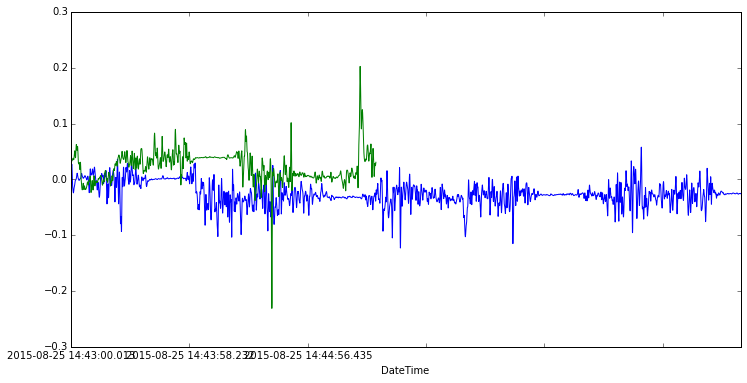

In [19]:
# compare bus gyroscopeZ2sm and car gyroscopeZ2sm
#q1['gyroscopeXsm'].plot(color='blue', figsize=(12,6), kind='hist', bins=40, alpha=0.4) # car
#q3['gyroscopeXsm'].plot(color='green', kind='hist', bins=40, alpha=0.4) # bus
q1['gyroscopeXsm'].plot(color='blue', figsize=(12,6)) # car
q3['gyroscopeXsm'].plot(color='green') # bus

#### This seems like an enormous difference in pitch angle and is really hard to understand.  My guess is that it is somehow an artifact of the experimental setup. Perhaps the quaternion rotation of gyroscopeXYZ is not quite perfect.

#### Another interesting avenue to pursue is features in Fourier space

In [35]:
# Generate Fourier Transform of features
fftfeatures = []
for i in features:
    reals = np.real(np.fft.rfft(df[i]))
    imags = np.imag(np.fft.rfft(df[i]))
    complexs = [reals[0]]
    n = len(reals)
    if n % 2 == 0:
        complexs.append(imags[0])
    for j in range(1, n - 1):
        complexs.append(reals[j])
        complexs.append(imags[j])
    complexs.append(reals[j])
    if len(df) > len(complexs):
        complexs.append(imags[j])
    df['f' + i] = complexs
    fftfeatures.append('f' + i)
features.extend(fftfeatures)

In [38]:
# separate into quarters for train and validation
q1 = df[(df.index <= '2015-08-25 14:38:30') & 
        (df.index > '2015-08-25 14:33:00')]
q2 = df[(df.index > '2015-08-25 14:38:30') & 
        (df.index <= '2015-08-25 14:42:00')]
q3 = df[(df.index > '2015-08-25 14:43:00') & 
        (df.index <= '2015-08-25 14:45:30')]
q4 = df[(df.index > '2015-08-25 14:45:30') & 
        (df.index <= '2015-08-25 14:48:00')]
traindf = pd.concat([q1, q3])
validationdf = pd.concat([q2, q4])

In [39]:
# Make the training and validation sets
X_train = traindf[fftfeatures].values
y_train = traindf['class'].values
X_test = validationdf[fftfeatures].values
y_test = validationdf['class'].values

In [40]:
# train a random forest
clf = RandomForestClassifier(n_estimators=200)

In [41]:
# get the 5-fold cross-validation score
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(scores, scores.mean(), scores.std())

(array([ 0.76773802,  1.        ,  1.        ,  0.97934386,  0.87302552]), 0.92402148067203727, 0.091248171911248468)


In [42]:
# apply model to test set
clf.fit(X_train, y_train)
predict_y = clf.predict(X_test)

In [43]:
# obtain accuracy score
testscore = accuracy_score(y_test, predict_y)
print("Accuracy score on test set: %6.3f" % testscore)

Accuracy score on test set:  0.731


#### Better accuracy on the test set: 73%.  We are still overfitting here, since we got 92% accuracy on the training set.  Using the Fourier domain seems to be helpful.

In [44]:
# Inspect feature importances
for i, ifeature in enumerate(fftfeatures):
    print(ifeature + ': %6.4f' % clf.feature_importances_[i])

fuserAccelerationX: 0.0009
fuserAccelerationY: 0.0010
fuserAccelerationZ: 0.0010
fgyroscopeX: 0.0011
fgyroscopeY: 0.0013
fgyroscopeZ: 0.0031
fuserAccelerationXsm: 0.0387
fuserAccelerationX2sm: 0.0641
fuserAccelerationYsm: 0.0299
fuserAccelerationY2sm: 0.0614
fuserAccelerationZsm: 0.0245
fuserAccelerationZ2sm: 0.0598
fgyroscopeXsm: 0.0374
fgyroscopeX2sm: 0.0661
fgyroscopeYsm: 0.0436
fgyroscopeY2sm: 0.0424
fgyroscopeZsm: 0.0531
fgyroscopeZ2sm: 0.0595
fuserAccelerationXjerk: 0.0041
fuserAccelerationYjerk: 0.0022
fuserAccelerationZjerk: 0.0027
fgyroscopeXjerk: 0.0032
fgyroscopeYjerk: 0.0043
fgyroscopeZjerk: 0.0022
fuserAccelerationXsmjerk: 0.0577
fuserAccelerationX2smjerk: 0.0279
fuserAccelerationYsmjerk: 0.0371
fuserAccelerationY2smjerk: 0.0020
fuserAccelerationZsmjerk: 0.0256
fuserAccelerationZ2smjerk: 0.0012
fgyroscopeXsmjerk: 0.0422
fgyroscopeX2smjerk: 0.0177
fgyroscopeYsmjerk: 0.0583
fgyroscopeY2smjerk: 0.0104
fgyroscopeZsmjerk: 0.0391
fgyroscopeZ2smjerk: 0.0731


#### There is no single feature that is particularly important.  This helps me feel more confident that the results will generalize well to new samples.  74% accuracy in 5 minute ride samples isn't too bad!